In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os, random, json, PIL, shutil, re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras import layers as L, Model

# GPU strategy setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Running on GPU: {gpus[0].name}")
else:
    print("GPU not found. Using default CPU strategy.")

strategy = tf.distribute.get_strategy()


Running on GPU: /physical_device:GPU:0


In [36]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 120
BATCH_SIZE = 1

MONET_DIR = "/content/drive/My Drive/gan-getting-started/monet_jpg"
PHOTO_DIR = "/content/drive/My Drive/gan-getting-started/photo_jpg"


monet_paths = [os.path.join(MONET_DIR, fname) for fname in os.listdir(MONET_DIR) if fname.endswith(".jpg")]
photo_paths = [os.path.join(PHOTO_DIR, fname) for fname in os.listdir(PHOTO_DIR) if fname.endswith(".jpg")]

print(f"Monet images: {len(monet_paths)}")
print(f"Photo images: {len(photo_paths)}")

n_monet_samples = len(monet_paths)
n_photo_samples = len(photo_paths)

Monet images: 300
Photo images: 7041


In [37]:
def decode_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

def load_dataset(image_paths, training=True):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

BUFFER_SIZE = 1000
monet_dataset = load_dataset(monet_paths)
photo_dataset = load_dataset(photo_paths)

In [38]:
Norm = lambda: tf.keras.layers.LayerNormalization(epsilon=1e-5)

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(Norm())
    result.add(L.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(Norm())
    if apply_dropout:
        result.add(L.Dropout(0.5))
    result.add(L.ReLU())
    return result



**FOR LATER USE**

In [ ]:
def preprocess_image(path):
    img = Image.open(path).resize((512, 512)) 
    img = np.array(img).astype(np.float32)
    img = (img / 127.5) - 1.0  
    img = np.expand_dims(img, axis=0)  
    return img

# --- Dataset Loaders ---
def load_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTO)
    return dataset

def get_gan_dataset(monet_paths, photo_paths, repeat=True, shuffle=True, batch_size=BATCH_SIZE):
    monet_ds = load_dataset(monet_paths)
    photo_ds = load_dataset(photo_paths)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)

    monet_ds = monet_ds.batch(batch_size, drop_remainder=True).cache().prefetch(AUTO)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True).cache().prefetch(AUTO)

    return tf.data.Dataset.zip((monet_ds, photo_ds))

# --- Display Functions ---
def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15 * row / col)))
    for j in range(row * col):
        monet_img, photo_img = next(ds_iter)
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow((monet_img[0] * 0.5 + 0.5).numpy())  # Display Monet image
    plt.show()


def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15 * row / col)))
    for j in range(row * col):
        image = next(ds_iter)
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        # If image is batched, use image[0]
        if isinstance(image, tuple) or len(image.shape) == 4:
            image = image[0]
        plt.imshow((image * 0.5 + 0.5).numpy())
    plt.show()


# --- Prediction + Save ---
def predict_and_save(input_ds, generator_model, output_path):
    os.makedirs(output_path, exist_ok=True)
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)  # Re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(os.path.join(output_path, f"{i}.jpg"))
        i += 1

In [40]:
def Generator():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])
    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
    ]
    up_stack = [
        upsample(128, 4),
        upsample(64, 4),
    ]
    x = inputs
    for down in down_stack:
        x = down(x)
    for up in up_stack:
        x = up(x)
    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    x = last(x)
    return Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')
    x = downsample(64, 4, False)(inp)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    last = L.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    return Model(inputs=inp, outputs=last)

with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real), real, from_logits=True)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated), generated, from_logits=True)
        return tf.reduce_mean(real_loss + generated_loss)

    def generator_loss(generated):
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(generated), generated, from_logits=True))

    def cycle_loss(real_image, cycled_image):
        return tf.reduce_mean(tf.abs(real_image - cycled_image)) * 10.0

    def identity_loss(real_image, same_image):
        return tf.reduce_mean(tf.abs(real_image - same_image)) * 5.0

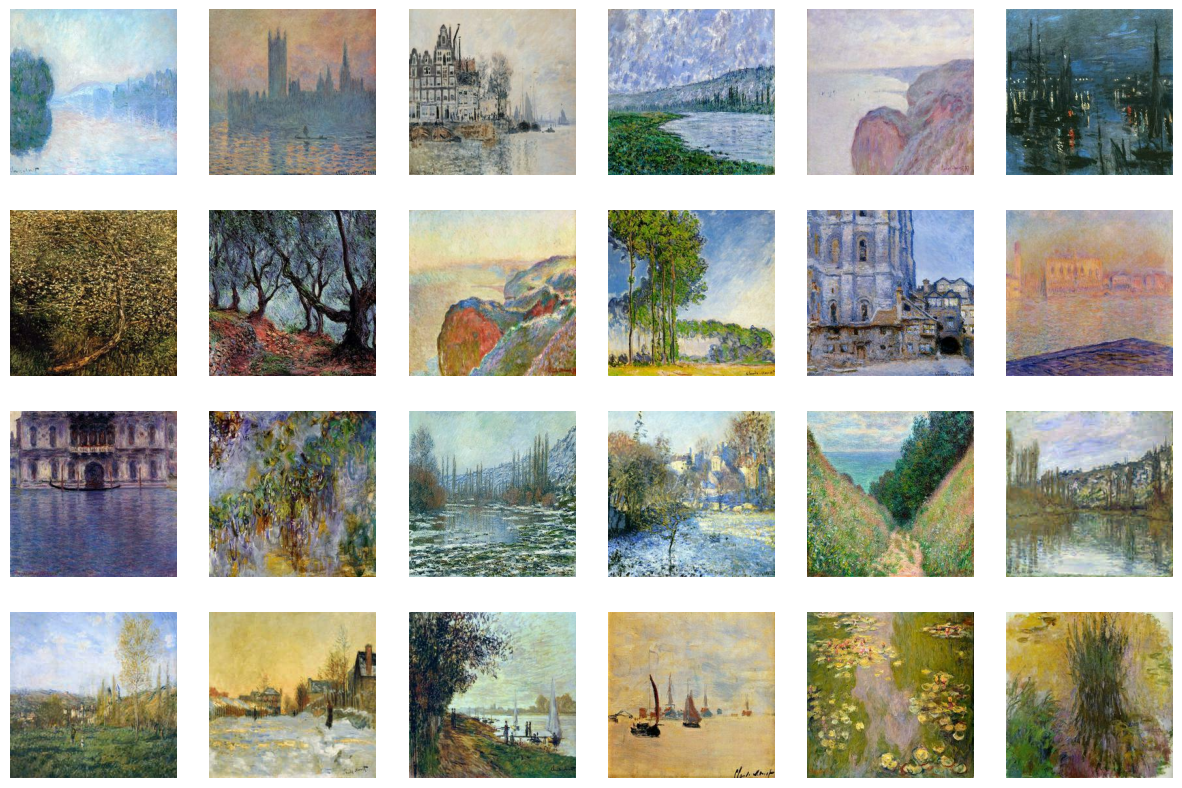

In [41]:
AUTO = tf.data.AUTOTUNE
display_samples(load_dataset(monet_paths), 4, 6)


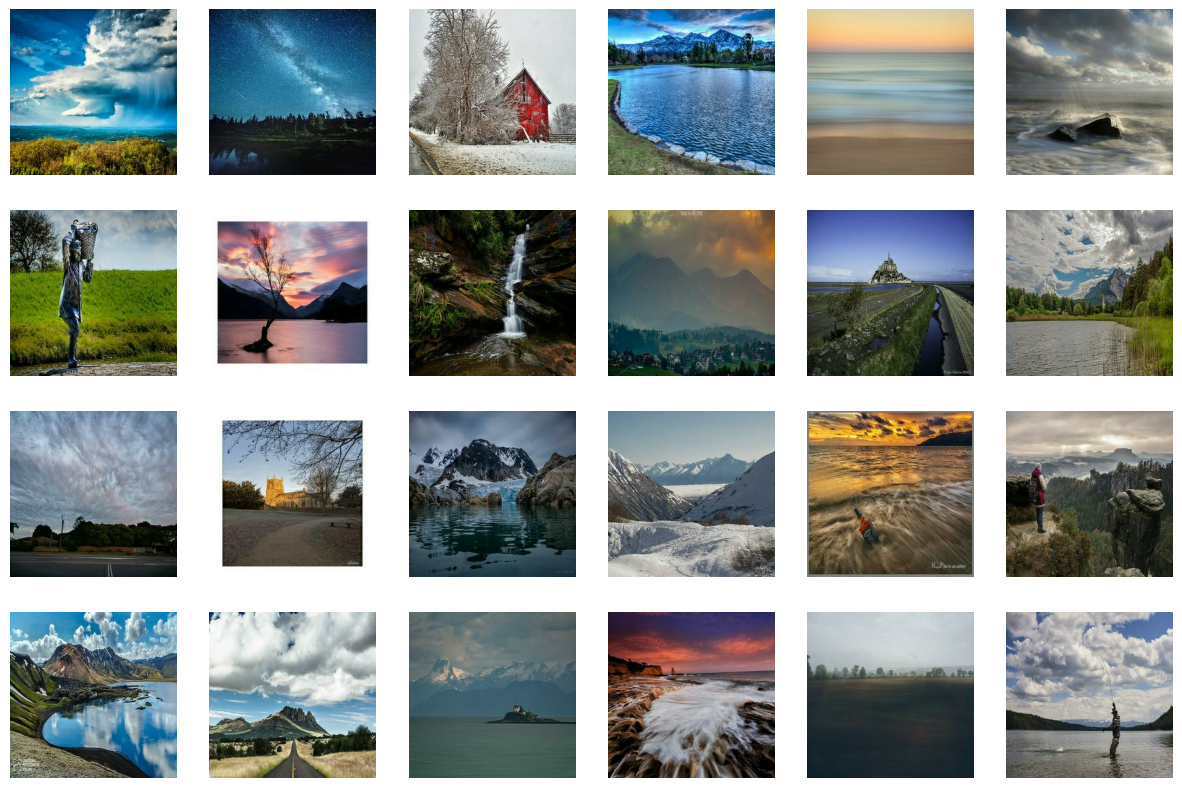

In [42]:
display_samples(load_dataset(photo_paths), 4, 6)

In [43]:
class CycleGAN(Model):
    def __init__(self):
        super().__init__()
        self.gen_G = monet_generator
        self.gen_F = photo_generator
        self.disc_X = photo_discriminator
        self.disc_Y = monet_discriminator

    def compile(self, gen_G_opt, gen_F_opt, disc_X_opt, disc_Y_opt, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super().compile()
        self.gen_G_opt = gen_G_opt
        self.gen_F_opt = gen_F_opt
        self.disc_X_opt = disc_X_opt
        self.disc_Y_opt = disc_Y_opt
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.gen_G(real_x, training=True)
            cycled_x = self.gen_F(fake_y, training=True)

            fake_x = self.gen_F(real_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            disc_real_x = self.disc_X(real_x, training=True)
            disc_real_y = self.disc_Y(real_y, training=True)

            disc_fake_x = self.disc_X(fake_x, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            gen_G_loss = self.gen_loss_fn(disc_fake_y)
            gen_F_loss = self.gen_loss_fn(disc_fake_x)

            total_cycle_loss = self.cycle_loss_fn(real_x, cycled_x) + self.cycle_loss_fn(real_y, cycled_y)

            total_gen_G_loss = gen_G_loss + total_cycle_loss + self.identity_loss_fn(real_y, same_y)
            total_gen_F_loss = gen_F_loss + total_cycle_loss + self.identity_loss_fn(real_x, same_x)

            disc_X_loss = self.disc_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.disc_loss_fn(disc_real_y, disc_fake_y)

        grads_gen_G = tape.gradient(total_gen_G_loss, self.gen_G.trainable_variables)
        grads_gen_F = tape.gradient(total_gen_F_loss, self.gen_F.trainable_variables)
        grads_disc_X = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        grads_disc_Y = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        self.gen_G_opt.apply_gradients(zip(grads_gen_G, self.gen_G.trainable_variables))
        self.gen_F_opt.apply_gradients(zip(grads_gen_F, self.gen_F.trainable_variables))
        self.disc_X_opt.apply_gradients(zip(grads_disc_X, self.disc_X.trainable_variables))
        self.disc_Y_opt.apply_gradients(zip(grads_disc_Y, self.disc_Y.trainable_variables))

        return {
            "gen_G_loss": total_gen_G_loss,
            "gen_F_loss": total_gen_F_loss,
            "disc_X_loss": disc_X_loss,
            "disc_Y_loss": disc_Y_loss
        }

cyclegan_model = CycleGAN()
cyclegan_model.compile(
    gen_G_opt=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_F_opt=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_X_opt=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_Y_opt=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=cycle_loss,
    identity_loss_fn=identity_loss
)



In [44]:
import tensorflow as tf

# === Define datasets ===
train_dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset))

# === Define and compile model ===
cyclegan_model = CycleGAN()
cyclegan_model.compile(
    gen_G_opt=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_F_opt=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_X_opt=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_Y_opt=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=cycle_loss,
    identity_loss_fn=identity_loss
)

# === Train model ===
cyclegan_model.fit(train_dataset, epochs=EPOCHS, verbose=1)

# Save all four models in the current Colab session
cyclegan_model.gen_G.save('/content/gen_G.keras')       # Photo → Monet
cyclegan_model.gen_F.save('/content/gen_F.keras')       # Monet → Photo
cyclegan_model.disc_X.save('/content/disc_X.keras')     # Discriminator for photos
cyclegan_model.disc_Y.save('/content/disc_Y.keras')


Epoch 1/120


KeyboardInterrupt: 

In [34]:
  # Discriminator for monets


In [47]:
from tensorflow.keras.models import load_model

# Load the generator model (Photo → Monet)
gen_G = load_model('/content/gen_G.keras', compile=False)


In [48]:
from PIL import Image
import numpy as np

def preprocess_image(path):
    img = Image.open(path).resize((256, 256))
    img = np.array(img).astype(np.float32)
    img = (img / 127.5) - 1.0  # Normalize to [-1, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [54]:
# Replace with your actual image path
photo_path = '/content/WhatsApp Image 2025-05-28 at 14.10.21.jpeg'
input_image = preprocess_image(photo_path)

# Run inference
monet_image = gen_G(input_image, training=False)


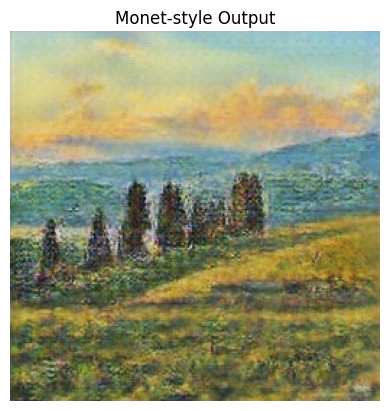

In [55]:
import matplotlib.pyplot as plt

# Remove batch dimension and convert back to [0, 1]
monet_image = (monet_image[0] + 1.0) / 2.0

plt.imshow(monet_image)
plt.axis('off')
plt.title("Monet-style Output")
plt.show()


In [51]:
monet_image_uint8 = (monet_image.numpy() * 255).astype(np.uint8)
Image.fromarray(monet_image_uint8).save("/content/monet_output.jpg")
